<a href="https://colab.research.google.com/github/ssrbazpur/Data-Science/blob/master/Finalone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using BQML to Predict Demand for NYC Taxis based on the Weather Forecast

Goal is to build a predictive model using only BigQuery standard SQL. Since this is a Python notebook, we'll use some of the features of Python to analyze the data (ie. a loss function for calculating RSME), but the model itself and it's preditive comes comes from BigQuery alone. This is called BigQuery ML (BQML) and we couldn't be more excited to try it out!

To get started, we'll take a [classic Machine Learning example](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/CPB100/lab4a/demandforecast.ipynb) and remove the TensorFlow piece. Rest assured, TensorFlow is still being used, but it has been abstracted from view. You'll notice this model performs significantly better than the predessor, and it do this with no customatization on the model.


In [0]:
import pandas as pd
import numpy as np
import sys
from google.cloud import bigquery
from google.colab import auth
auth.authenticate_user()

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/My Drive/Data Science/nyc-taxi-265120-baf9a3e4cf9b.json"
%reload_ext google.cloud.bigquery

You'll need to define some variables that will be used throughout the notebook. These are the GCP `project_id`, the `model_name` can be any name you prefer, and finally the `dateset_name`. The dataset needs to exist in the same project as the `project_id` and you need to have sufficient access to create and delete.

In [0]:
#@title Setup Project Variables { run: "auto", display-mode: "form" }
project_id = 'nyc-taxi-265120' #@param {type:"string"}
dataset_name = "Taxitemp" #@param {type:"string"}
model_name = "pats_taxi_model" #@param {type:"string"}
eval_name = model_name + "_eval"
client = bigquery.Client(project=project_id)

## Create a Linear Regression Model

In [0]:

project_id = 'nyc-taxi-265120' #@param{type:"string"}
from google.cloud import bigquery
#from google.cloud import bigquery_storage_v1beta1
# Create BigQuery client
client = bigquery.Client(project = project_id)
# Create BigQuery storage client
#bq_storage_client = bigquery_storage_v1beta1.BigQueryStorageClient()

### Creating labeled data
This query can be run in BigQuery on its own. Try it out! This query gives us 3 years of taxi and weather data for the NYC region. Those two datasets represent our labeled data: weather as our features (or metrics) and taxi trips as our label (target, class, objective, etc...).

In [0]:
query = """
with td as(
WITH AB AS
(
SELECT  CAST(tpep_pickup_datetime AS DATETIME) AS PICKUP,* FROM `nyc-taxi-265120.NYC.2019_CreatedDataset`
)  
SELECT  PICKUP,CAST(EXTRACT (YEAR from PICKUP) AS STRING) AS year,EXTRACT (DAYOFYEAR from PICKUP) AS daynumber,EXTRACT (HOUR from PICKUP) AS hour, cast(PULocationID as STRING) as LOCATION,COUNT(*) AS numtrips FROM AB group by PICKUP,year,daynumber,hour,LOCATION),points AS
(SELECT *,ST_CENTROID(zone_geom) as p FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)


SELECT 
cast(DATE(td.PICKUP) as STRING) AS A1,
points.zone_id,

CAST(TIME(DATETIME_TRUNC(td.PICKUP, HOUR)) as string) rounded_to_hour,

 
 
    SUM(td.numtrips) as label,
   
 
  FROM  td INNER JOIN points ON points.zone_id=td.LOCATION AND
  
  eXTRACT (YEAR from PICKUP) =2019 AND td.daynumber<150
  group by zone_id,A1,rounded_to_hour
  
  



"""
df = client.query(query).to_dataframe()


In [123]:
df.head()

,A1,zone_id,rounded_to_hour,label
0,2019-02-06,132,00:00:00,131
1,2019-02-05,88,00:00:00,16
2,2019-02-05,79,00:00:00,158
3,2019-03-30,75,00:00:00,44
4,2019-03-31,68,00:00:00,386


In [0]:
df["time"]=pd.to_datetime(df['A1'] + ' ' + df['rounded_to_hour'])

In [125]:
df.head()

,A1,zone_id,rounded_to_hour,label,time
0,2019-02-06,132,00:00:00,131,2019-02-06
1,2019-02-05,88,00:00:00,16,2019-02-05
2,2019-02-05,79,00:00:00,158,2019-02-05
3,2019-03-30,75,00:00:00,44,2019-03-30
4,2019-03-31,68,00:00:00,386,2019-03-31


In [0]:
a=df.pivot_table("label", "time", "zone_id")

In [127]:
a.head()

zone_id,1,10,100,101,102,106,107,108,109,11,111,112,113,114,115,116,117,118,119,12,120,121,122,123,124,125,126,127,128,129,13,130,131,132,133,134,135,136,137,138,...,63,64,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,9,90,91,92,93,94,95,96,97,98,99
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,2.0,54.0,NaN,NaN,3.0,422.0,NaN,NaN,2.0,NaN,12.0,239.0,293.0,NaN,29.0,NaN,NaN,2.0,4.0,NaN,NaN,2.0,1.0,1.0,73.0,2.0,2.0,NaN,15.0,64.0,4.0,NaN,205.0,2.0,1.0,NaN,NaN,180.0,56.0,...,1.0,NaN,21.0,8.0,NaN,444.0,NaN,25.0,4.0,1.0,NaN,NaN,67.0,91.0,5.0,2.0,2.0,657.0,NaN,14.0,NaN,4.0,NaN,NaN,NaN,NaN,87.0,45.0,2.0,NaN,281.0,NaN,1.0,1.0,1.0,NaN,NaN,15.0,NaN,NaN
2019-01-01 01:00:00,NaN,3.0,79.0,NaN,NaN,7.0,610.0,NaN,NaN,NaN,NaN,42.0,153.0,167.0,NaN,58.0,NaN,NaN,NaN,4.0,1.0,NaN,NaN,NaN,NaN,74.0,NaN,7.0,1.0,27.0,53.0,1.0,NaN,103.0,1.0,2.0,NaN,4.0,273.0,10.0,...,NaN,1.0,35.0,25.0,1.0,401.0,4.0,60.0,4.0,1.0,1.0,NaN,100.0,97.0,3.0,NaN,2.0,744.0,1.0,56.0,1.0,11.0,3.0,NaN,3.0,NaN,164.0,56.0,1.0,NaN,243.0,1.0,2.0,NaN,2.0,1.0,NaN,39.0,1.0,NaN
2019-01-01 02:00:00,1.0,NaN,114.0,1.0,NaN,4.0,472.0,NaN,NaN,NaN,NaN,43.0,143.0,196.0,NaN,53.0,NaN,NaN,1.0,7.0,1.0,NaN,NaN,NaN,NaN,92.0,1.0,6.0,NaN,48.0,37.0,2.0,NaN,51.0,NaN,NaN,NaN,2.0,218.0,3.0,...,NaN,NaN,33.0,12.0,NaN,390.0,1.0,59.0,4.0,NaN,1.0,NaN,74.0,83.0,1.0,NaN,NaN,837.0,NaN,52.0,1.0,15.0,6.0,NaN,1.0,NaN,111.0,42.0,2.0,NaN,219.0,NaN,NaN,NaN,NaN,6.0,NaN,39.0,NaN,NaN
2019-01-01 03:00:00,NaN,NaN,161.0,NaN,NaN,7.0,341.0,1.0,NaN,NaN,NaN,25.0,156.0,263.0,NaN,37.0,NaN,NaN,3.0,1.0,NaN,1.0,NaN,NaN,NaN,50.0,1.0,4.0,NaN,31.0,13.0,1.0,NaN,80.0,2.0,2.0,NaN,1.0,182.0,2.0,...,NaN,NaN,21.0,3.0,NaN,390.0,2.0,86.0,3.0,2.0,NaN,NaN,56.0,59.0,1.0,1.0,NaN,873.0,NaN,51.0,NaN,16.0,10.0,NaN,NaN,NaN,63.0,42.0,2.0,NaN,259.0,NaN,2.0,1.0,NaN,4.0,1.0,15.0,NaN,NaN
2019-01-01 04:00:00,NaN,1.0,99.0,NaN,NaN,5.0,261.0,NaN,2.0,NaN,NaN,18.0,67.0,148.0,NaN,33.0,NaN,NaN,2.0,1.0,NaN,NaN,NaN,1.0,NaN,37.0,NaN,3.0,NaN,36.0,13.0,1.0,1.0,47.0,NaN,NaN,NaN,3.0,100.0,4.0,...,NaN,NaN,10.0,1.0,3.0,274.0,3.0,82.0,3.0,NaN,NaN,NaN,50.0,47.0,1.0,1.0,1.0,442.0,NaN,40.0,NaN,23.0,9.0,NaN,2.0,NaN,27.0,30.0,1.0,NaN,179.0,2.0,NaN,1.0,2.0,4.0,NaN,13.0,NaN,NaN


In [0]:
b=df.pivot_table("label", "time", "zone_id").unstack().reset_index()

In [129]:
b.head()

,zone_id,time,0
0,1,2019-01-01 00:00:00,NaN
1,1,2019-01-01 01:00:00,NaN
2,1,2019-01-01 02:00:00,1.0
3,1,2019-01-01 03:00:00,NaN
4,1,2019-01-01 04:00:00,NaN


In [0]:
b.rename( columns={0:'pickups'}, inplace=True )

In [131]:
b.head()

,zone_id,time,pickups
0,1,2019-01-01 00:00:00,NaN
1,1,2019-01-01 01:00:00,NaN
2,1,2019-01-01 02:00:00,1.0
3,1,2019-01-01 03:00:00,NaN
4,1,2019-01-01 04:00:00,NaN


In [0]:
b1=b.fillna(0)

In [133]:
b1.head()

,zone_id,time,pickups
0,1,2019-01-01 00:00:00,0.0
1,1,2019-01-01 01:00:00,0.0
2,1,2019-01-01 02:00:00,1.0
3,1,2019-01-01 03:00:00,0.0
4,1,2019-01-01 04:00:00,0.0


In [134]:
b1.shape

(922350, 3)

In [135]:
!pip install datalab

In [0]:
from datalab.context import Context

In [0]:
import pandas_gbq as gbq

In [0]:
from google.oauth2 import service_account

In [0]:
#Dont run this
gbq.to_gbq(b1, 'hello.test_table', 'nyc-taxi-265120', if_exists='append')

In [0]:
query = """
with wd as (
    SELECT 
        cast(year as STRING) as year,
        EXTRACT (DAYOFYEAR FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP)) AS daynumber, 
        MIN(EXTRACT (DAYOFWEEK FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP))) dayofweek,
        MIN(min) mintemp, MAX(max) maxtemp, MAX(IF(prcp=99.99,0,prcp)) rain
    FROM `bigquery-public-data.noaa_gsod.gsod2019`
    WHERE stn='725030'   --station id 725030=LaGuardia
    GROUP BY 1,2 
  
  -- TAXI DATA
  ),
TD AS(

SELECT  zone_id, time, pickups ,CAST(EXTRACT (YEAR from time) AS STRING) AS year,EXTRACT (DAYOFYEAR from time) AS daynumber,EXTRACT (HOUR from time) AS hour from `nyc-taxi-265120.hello.test_table` ),points AS
(SELECT *,ST_CENTROID(zone_geom) as p FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)


SELECT 
points.zone_id,
td.time,
td.daynumber,
td.hour,
cast(wd.dayofweek as STRING) as dayofweek, 
    wd.mintemp, 
    wd.maxtemp,
    wd.rain,
 td.pickups,

    ST_ASTEXT(points.p) AS P,
 
  FROM wd, td INNER JOIN points ON points.zone_id=td.zone_id
  where wd.year = td.year AND
  wd.daynumber = td.daynumber
  group by zone_id,time,daynumber,hour,pickups,P,dayofweek, mintemp, maxtemp, rain

"""
df2 = client.query(query).to_dataframe()


In [140]:
df2.head()

,zone_id,time,daynumber,hour,dayofweek,mintemp,maxtemp,rain,pickups,P
0,1,2019-01-01 00:00:00+00:00,1,0,3,35.1,60.1,1.39,0.0,POINT(-74.1740015721158 40.6918301401778)
1,1,2019-01-01 01:00:00+00:00,1,1,3,35.1,60.1,1.39,0.0,POINT(-74.1740015721158 40.6918301401778)
2,1,2019-01-01 03:00:00+00:00,1,3,3,35.1,60.1,1.39,0.0,POINT(-74.1740015721158 40.6918301401778)
3,1,2019-01-01 04:00:00+00:00,1,4,3,35.1,60.1,1.39,0.0,POINT(-74.1740015721158 40.6918301401778)
4,1,2019-01-01 07:00:00+00:00,1,7,3,35.1,60.1,1.39,0.0,POINT(-74.1740015721158 40.6918301401778)


In [141]:
print df2.shape

(925925, 10)


In [142]:
max(df2['pickups'])

1425.0

In [0]:
df2.drop('P', axis=1, inplace=True)

In [144]:
df2.head()

,zone_id,time,daynumber,hour,dayofweek,mintemp,maxtemp,rain,pickups
0,1,2019-01-01 00:00:00+00:00,1,0,3,35.1,60.1,1.39,0.0
1,1,2019-01-01 01:00:00+00:00,1,1,3,35.1,60.1,1.39,0.0
2,1,2019-01-01 03:00:00+00:00,1,3,3,35.1,60.1,1.39,0.0
3,1,2019-01-01 04:00:00+00:00,1,4,3,35.1,60.1,1.39,0.0
4,1,2019-01-01 07:00:00+00:00,1,7,3,35.1,60.1,1.39,0.0


In [0]:
df2.drop('time', axis=1, inplace=True)

In [146]:
df2.head()

,zone_id,daynumber,hour,dayofweek,mintemp,maxtemp,rain,pickups
0,1,1,0,3,35.1,60.1,1.39,0.0
1,1,1,1,3,35.1,60.1,1.39,0.0
2,1,1,3,3,35.1,60.1,1.39,0.0
3,1,1,4,3,35.1,60.1,1.39,0.0
4,1,1,7,3,35.1,60.1,1.39,0.0


In [147]:
df2.isnull().sum()

zone_id      0
daynumber    0
hour         0
dayofweek    0
mintemp      0
maxtemp      0
rain         0
pickups      0
dtype: int64

In [0]:
df2["zone_id"] = df2["zone_id"].astype(int)
df2["dayofweek"] = df2["dayofweek"].astype(int)

In [149]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925925 entries, 0 to 925924
Data columns (total 8 columns):
zone_id      925925 non-null int64
daynumber    925925 non-null int64
hour         925925 non-null int64
dayofweek    925925 non-null int64
mintemp      925925 non-null float64
maxtemp      925925 non-null float64
rain         925925 non-null float64
pickups      925925 non-null float64
dtypes: float64(4), int64(4)
memory usage: 56.5 MB


In [0]:
train=df2

In [151]:
train.head()

,zone_id,daynumber,hour,dayofweek,mintemp,maxtemp,rain,pickups
0,1,1,0,3,35.1,60.1,1.39,0.0
1,1,1,1,3,35.1,60.1,1.39,0.0
2,1,1,3,3,35.1,60.1,1.39,0.0
3,1,1,4,3,35.1,60.1,1.39,0.0
4,1,1,7,3,35.1,60.1,1.39,0.0


In [0]:
train=train.drop('pickups', axis=1)

In [153]:
max(df2['pickups'])

1425.0

In [0]:
y=df2['pickups']
X=train

In [155]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925925 entries, 0 to 925924
Data columns (total 7 columns):
zone_id      925925 non-null int64
daynumber    925925 non-null int64
hour         925925 non-null int64
dayofweek    925925 non-null int64
mintemp      925925 non-null float64
maxtemp      925925 non-null float64
rain         925925 non-null float64
dtypes: float64(3), int64(4)
memory usage: 49.4 MB


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [157]:
y_train.shape

(694443,)

In [158]:
max(y)

1425.0

In [159]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 694443 entries, 36204 to 305711
Data columns (total 7 columns):
zone_id      694443 non-null int64
daynumber    694443 non-null int64
hour         694443 non-null int64
dayofweek    694443 non-null int64
mintemp      694443 non-null float64
maxtemp      694443 non-null float64
rain         694443 non-null float64
dtypes: float64(3), int64(4)
memory usage: 42.4 MB


In [0]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [0]:
import lightgbm as lgb

In [163]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)


/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [0]:
rf_predict = rf.predict(X_test)

In [166]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, rf_predict) ** 0.5)

('The rmse of prediction is:', 15.872395370120607)


In [0]:
ypred= rf.predict(X_test.head(10))

In [172]:
ypred

array([ 0. ,  0. ,  5.9,  2.4,  0.2,  1.4, 98.7,  8.5,  0.1,  0. ])

In [174]:
y_test.head(10)

837074     0.0
238577     0.0
485529     4.0
612843     1.0
602316     0.0
57927      3.0
746858    95.0
821802    12.0
120519     0.0
783847     0.0
Name: pickups, dtype: float64

In [178]:
X_test.shape

(231482, 7)

In [184]:
print( rf.predict([[150,2,0,3,20,40,1]]))

[0.]


In [0]:
gbm = lgb.LGBMRegressor(num_leaves=80,
                        learning_rate=0.05,
                        n_estimators=20)

In [0]:
model=gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=100)

In [0]:
y_pred = model.predict(X_test, num_iteration=gbm.best_iteration_)

In [0]:
import numpy as np
from sklearn import linear_model

In [0]:
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf.fit(X_train, y_train)

In [111]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

('The rmse of prediction is:', 57.82973561752418)


In [0]:
ypred= gbm.predict(X_test.head(1), num_iteration=gbm.best_iteration_)

In [113]:
ypred

array([17.14182072])

In [114]:
X_test.head(1)

,zone_id,daynumber,hour,dayofweek,mintemp,maxtemp,rain
837074,187,135,21,4,44.1,69.1,0.21


In [116]:
y_test.head(1)

837074    0.0
Name: pickups, dtype: float64

In [0]:
import pickle
pickle.dump(rf, open('/content/drive/My Drive/Data Science/modelfinal2.pkl','wb'))

In [0]:
 model = pickle.load(open('/content/drive/My Drive/Data Science/modelfinal.pkl','rb'))
print(model.predict([[1,1,1,0,0,0,0]]))

ValueError: ignored

In [0]:
y_test.head(1)

118697    383
Name: label, dtype: int64

In [0]:
print('Feature importances:', list(gbm.feature_importances_))


('Feature importances:', [0, 0, 20, 0, 0, 0, 575, 5])


In [0]:
train_data = lgb.Dataset(data, label=label, feature_name=['c1', 'c2', 'c3'], categorical_feature=['c3'])

In [0]:
num_round = 10
bst = lgb.train(param, train_data, num_round, valid_sets=[validation_data])

In [0]:
xgboost = xgb.XGBClassifier(n_jobs=4,max_depth=3, n_estimators=3, learning_rate=0.05).fit(X_train, y_train)

In [0]:
y_test

In [0]:
xgb_prediction = xgboost.predict(X_test)


In [0]:

max(xgb_prediction)

3

In [0]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [0]:
import pickle


pkl_filename = "/content/drive/My Drive/Data Science/pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(logreg, file)

In [0]:
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    


In [0]:
a=X_test.iloc[0]

In [0]:
type(a)

pandas.core.series.Series

In [0]:
a=a.to_numpy()

In [0]:
a.shape

(264,)

In [0]:
a = a.reshape((1, 264))

In [0]:
a.shape

(1, 264)

In [0]:
b=X_test.iloc[:0]
b

,dayofweek,mintemp,maxtemp,rain,hour,daynumber,Allerton/Pelham Gardens,Alphabet City,Arden Heights,Arrochar/Fort Wadsworth,Astoria,Astoria Park,Auburndale,Baisley Park,Bath Beach,Battery Park,Battery Park City,Bay Ridge,Bay Terrace/Fort Totten,Bayside,Bedford,Bedford Park,Bellerose,Belmont,Bensonhurst East,Bensonhurst West,Bloomfield/Emerson Hill,Bloomingdale,Boerum Hill,Borough Park,Breezy Point/Fort Tilden/Riis Beach,Briarwood/Jamaica Hills,Brighton Beach,Broad Channel,Bronx Park,Bronxdale,Brooklyn Heights,Brooklyn Navy Yard,Brownsville,Bushwick North,...,Stuy Town/Peter Cooper Village,Stuyvesant Heights,Sunnyside,Sunset Park East,Sunset Park West,Sutton Place/Turtle Bay North,Times Sq/Theatre District,TriBeCa/Civic Center,Two Bridges/Seward Park,UN/Turtle Bay South,Union Sq,University Heights/Morris Heights,Upper East Side North,Upper East Side South,Upper West Side North,Upper West Side South,Van Cortlandt Park,Van Cortlandt Village,Van Nest/Morris Park,Washington Heights North,Washington Heights South,West Brighton,West Chelsea/Hudson Yards,West Concourse,West Farms/Bronx River,West Village,Westchester Village/Unionport,Westerleigh,Whitestone,Willets Point,Williamsbridge/Olinville,Williamsburg (North Side),Williamsburg (South Side),Windsor Terrace,Woodhaven,Woodlawn/Wakefield,Woodside,World Trade Center,Yorkville East,Yorkville West


In [0]:
from pandas import DataFrame as df  
mydf = df(a).T  
b.loc[len(b)] = a  
print(b)

   dayofweek  mintemp  ...  Yorkville East  Yorkville West
0        3.0     34.0  ...             0.0             1.0

[1 rows x 264 columns]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:

logreg_prediction = pickle_model.predict(b)
print logreg_prediction

[2]


In [0]:
logreg_prediction = pickle_model.predict(X_test)
logreg_score=accuracy_score(y_test, logreg_prediction)
print(logreg_score)

0.7318378267133155


In [0]:
import numpy as np
x1=np.zeros((264))

In [0]:
x1

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### Data Exploration

     |████████████████████████████████| 225kB 9.4MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-cp27-none-any.whl size=32608 sha256=18151458d8c9d8f938e87273bfcc582a88324c30d55510b9181273a19e58f179
  Stored in directory: /root/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp
     |████████████████████████████████| 583kB 9.9MB/s 
ERROR: Could not find a version that satisfies the requirement pmdarima (from versions: none)
ERROR: No matching distribution found for pmdarima
     |████████████████████████████████| 15.4MB 283kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for statsmodels: filename=statsmodels-0.11.0-cp27-cp27mu-linux_x86_64.whl size=11103987 sha256=86741aa9f3025519ec737392bb9d0bde306db6f3bd30458f2d1b8c3adb9df173
  Stored in directory: /root/.cache/pip/wheels/1f/c9/bb/085ae5991327cb08b1dabf0564a3f148d0cd9c1395933c8286

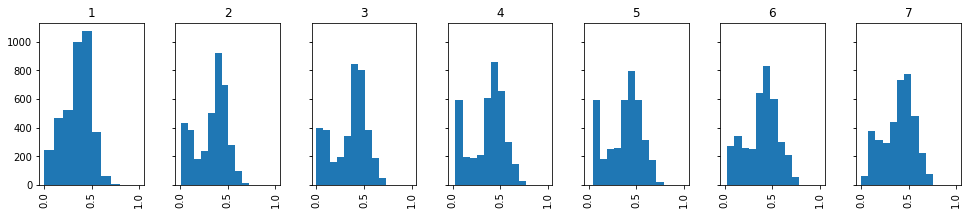

In [0]:
_ = data.hist(column='label',by='dayofweek', layout=(1,7), figsize=(16,3), sharey=True, sharex=True)

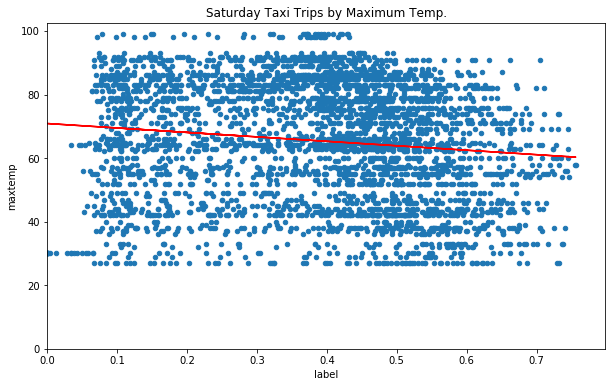

In [0]:
df = data[data.dayofweek == '7']
x = df.label
y = df.maxtemp
df.plot(kind="scatter",x="label",y="maxtemp", figsize=[10,6],ylim=0,xlim=0)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r")
plt.title("Saturday Taxi Trips by Maximum Temp.")
plt.show()

We see that trips made on a Saturday have a strong correlation with the maximum temperature. As the temperature descreases the demand for taxis increases. Our model is likely going to be able to use the predictive power found within this relationship between feature inputs and our target variable.

### Defining Model Parameters

In order to turn the above SQL into a predictive model, we simply need to `CREATE` the `MODEL` specifiying `linear_reg` or `logistic_reg`. This lets you build models for both regression (continous variable prediction) or classification (discreet variable prediction). Refer to the BQML documentation for more information on options and configuring your predictive model.

In [0]:
query = """
  CREATE OR REPLACE MODEL {0}.{1} 
    OPTIONS (
      model_type='linear_reg'
    ) as {2}
""".format(dataset_name, model_name, taxidemand)

### `CREATE MODEL` using `linear_reg`
The `for` loop will kick-off the `query_job` that has the `query` waiting to be processed. Once the job finishes it will continue through the `query_job` iterator until finished. At this point in time, the Google Cloud Python BigQuery API is throwing errors; these will be addressed in the near future.

In [0]:
query_job = client.query(query)
dataset_ref = client.dataset(dataset_name)
try: 
  for row in query_job:
    print row
except:
  print "ignoring this error: {}".format(sys.exc_info()) #  the model was successfully created

# confirm new tables exist in dataset
for i in client.list_tables(dataset_ref):
  if (i.table_id == model_name or i.table_id == eval_name):
     print i.table_id

pats_taxi_model


## Get `ml.EVALUATE()` info

### Baseline Mean Absolute Error
We want to establish a baseline to measure ourselves against. Below, we take the entire dataset (using the `taxidemand` query). Taking the mean of `numtrips` gives us an average daily trip count of `403,642`.  We'll use Pandas Mean Absolute Deviation function to calculate our MAE.

In [0]:
# Our prediction should beat the average MAE
df = client.query(taxidemand).to_dataframe()
print 'Average trips={0} with a MAE of {1}'.format(
    int(df.label.mean()*maxtrips), # scale value using the maxtrips variable
    int(df.label.mad()*maxtrips) # MAE, MAD = Mean Absolute Error, Mean Absolute Difference
)

Average trips=107 with a MAE of 129


### `ml.EVALUATE()`
We're looking to beat the MAE (shown below as `mean_absolute_error`)  of `50,419`. Fingers crossed!

In [0]:
query = ("select * from ml.EVALUATE(MODEL {0}.{1}, ({2}))") \
  .format(dataset_name, model_name, taxidemand)
df = client.query(query).to_dataframe()
df["mean_absolute_error"] = np.multiply(df["mean_absolute_error"],maxtrips).astype(int)
df

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,62,0.000979,0.000794,0.011059,0.669556,0.669556


Smashed it!

### Custom Loss Function
Do you read the articles that include "the hard way" in them? Perhaps you like to to see the math in action. Below we create a custom loss function and evaluate it against our model. We'll do this using the entire dataset (as defined by `taxidemand`).  We'd expect our `model_MAE` to match the `mean_absolute_error` value returned by the `ml.EVALUATE` function above.  Fingers crossed!

In [0]:
query = """
SELECT SUM(error) / COUNT(*) as model_MAE from (
  SELECT  abs(predicted_label-label) as error
          FROM ML.PREDICT(MODEL `{0}.{1}` , ({2}))
)
""".format(dataset_name, model_name, taxidemand)
df = client.query(query).to_dataframe()
print int(df.model_MAE*maxtrips)

4579


Sure enough, the math adds up!

## Get `ml.TRAINING_INFO()` for the model
This shows us how many training procedures were needed to reach convergence, and provides various metrics associated with the training run. The system performs hyperparameter tuning automatically in order to establish the best model settings.

In [0]:
query = "select * from ml.TRAINING_INFO(MODEL {0}.{1})".format(dataset_name, model_name)
df = client.query(query).to_dataframe()
df

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.000979,0.00098,None,14871


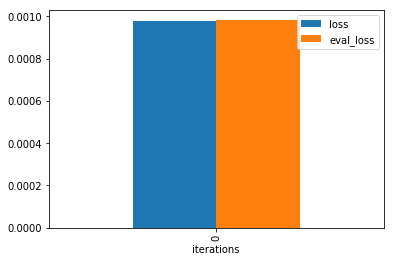

In [0]:
_ = df[['loss','eval_loss']].plot(kind='bar').set_xlabel('iterations')

## Get ml.FEATURE_INFO() for the model
This function prints out the descriptive statistics for the numerical features: min(), max(), avg(), and standard deviation. The category count shows the number of distinct values found within a categorical feature. Null count is important to note because the model will automatically convert nulls to the mean of the feature set (fairly standard practice, but could be controversial!)

In [0]:
query = "select * from ml.FEATURE_INFO(MODEL {0}.{1})".format(dataset_name, model_name)
df = client.query(query).to_dataframe()
df

,input,min,max,mean,median,stddev,category_count,null_count
0,dayofweek,NaN,NaN,NaN,NaN,NaN,7.0,NaN
1,mintemp,12.0,80.10,49.681762,51.1,15.973619,NaN,0.0
2,maxtemp,21.9,100.90,67.128720,69.1,17.223547,NaN,0.0
3,rain,0.0,2.79,0.120547,0.0,0.326036,NaN,0.0
4,hour,0.0,23.00,11.593986,12.0,6.947616,NaN,0.0
5,pickup_location_id,NaN,NaN,NaN,NaN,NaN,265.0,NaN


## Get `ml.WEIGHTS()` for the `dayofweek`
We created a linear model, here are the weights applied to the features of that model.

In [0]:
query = "select * from ml.WEIGHTS(MODEL {0}.{1})".format(dataset_name, model_name)
df = client.query(query).to_dataframe()
pd.DataFrame({ 
    "processed_input" : df.processed_input,
    "weights": df.weight 
})

,processed_input,weights
0,dayofweek,NaN
1,mintemp,-0.000120
2,maxtemp,0.000062
3,rain,-0.000455
4,hour,0.001457
5,pickup_location_id,NaN
6,__INTERCEPT__,42371.930773


In [0]:
query = "select * from ml.WEIGHTS(MODEL {0}.{1})".format(dataset_name, model_name)
df = client.query(query).to_dataframe()
df = pd.DataFrame(df.category_weights[0]).sort_values(by='category')
df.round(2)

,category,weight
2,1,-0.0
4,2,-0.0
5,3,-0.0
6,4,0.0
1,5,0.0
3,6,0.0
0,7,0.0


In [0]:
! pip install google-cloud-automl

     |████████████████████████████████| 378kB 8.8MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
  Found existing installation: google-api-core 1.13.0
    Uninstalling google-api-core-1.13.0:
      Successfully uninstalled google-api-core-1.13.0


In [0]:
from dask import dataframe as dd 
sd = dd.from_pandas(df, npartitions=3)

In [0]:
sd

,daynumber,hour,dayofweek,mintemp,maxtemp,rain,label,P,zone_id
npartitions=3,,,,,,,,,
0,int64,int64,object,float64,float64,float64,int64,object,object
195041,...,...,...,...,...,...,...,...,...
390082,...,...,...,...,...,...,...,...,...
585121,...,...,...,...,...,...,...,...,...


In [0]:
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client

/usr/local/lib/python2.7/dist-packages/distributed/bokeh/core.py:57: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 99] Cannot assign requested address
  warnings.warn('\n' + msg)
/usr/local/lib/python2.7/dist-packages/distributed/deploy/local.py:197: UserWarning: 
Could not launch service 'bokeh' on port 8787. Got the following message:

[Errno 99] Cannot assign requested address
  self.scheduler.start(scheduler_address)


Client Scheduler: inproc://172.28.0.2/122/1,Cluster Workers: 1 Cores: 4 Memory: 2.00 GB


## Make Predictions
Adjust the sliders to create new input values to be evaluated by the model.  The model takes the min and max tempertatures plus rainfall for any given day of the week and returns the predicted number of taxi trips that will occur that day. 

In [0]:
from dask.distributed import Client

# Scale up: connect to your own cluster with more resources
# see http://dask.pydata.org/en/latest/setup.html
client = Client(processes=False, threads_per_worker=2,
                n_workers=2, memory_limit='2GB')
client


distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB


Client Scheduler: inproc://172.28.0.2/122/31,Cluster Workers: 2 Cores: 4 Memory: 4.00 GB


In [0]:
!pip install dask-ml


     |████████████████████████████████| 112kB 9.8MB/s 


In [0]:
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARN

In [0]:
X, y = dask_ml.datasets.make_blobs(n_samples=1000000,
                                   chunks=100000,
                                   random_state=0,
                                   centers=3)
X = X.persist()
X

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB


dask.array<concatenate, shape=(1000000, 2), dtype=float64, chunksize=(100000, 2)>

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARN

In [0]:
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=2, oversampling_factor=10)
km.fit(X)

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARN

KMeans(algorithm='full', copy_x=True, init='k-means||', init_max_iter=2,
    max_iter=300, n_clusters=3, n_jobs=1, oversampling_factor=10,
    precompute_distances='auto', random_state=None, tol=0.0001)

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB


In [0]:
#@title Select your input parameters { run: "auto", display-mode: "form" }
mintemp = 29 #@param {type:"slider", min:1, max:90, step:1}
maxtemp = 67 #@param {type:"slider", min:10, max:110, step:1}
rain = 3.6 #@param {type:"slider", min:0, max:5, step:0.1}
dayofweek = 4 #@param {type:"slider", min:1, max:7, step:1}
hour = 7 #@param {type:"slider", min:0, max:24, step:1}


query = """
  select *
  from ml.PREDICT(
    MODEL {0}.{1},  (
      select  '{5}' as dayofweek,  
              {2} as mintemp,  
              {3} as maxtemp, 
              {4} as rain
    )
  )
""".format(dataset_name, 
           model_name, 
           mintemp,
           maxtemp,
           rain,
           dayofweek)

df = client.query(query).to_dataframe()
df["predicted_label"] = np.multiply(df["predicted_label"],maxtrips).astype(int)
df

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



NameError: ignored

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.40 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARN

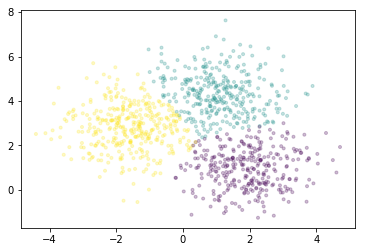

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.41 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.41 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.41 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.41 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.41 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARN

In [0]:
fig, ax = plt.subplots()
ax.scatter(X[::1000, 0], X[::1000, 1], marker='.', c=km.labels_[::1000],
           cmap='viridis', alpha=0.25);

In [0]:
import dask
import dask.array as da
from dask_ml.datasets import make_classification


n, d = 100000, 100

X, y = make_classification(n_samples=n, n_features=d,
                           chunks=n // 10, flip_y=0.2)
X

dask.array<normal, shape=(100000, 100), dtype=float64, chunksize=(10000, 100)>

In [0]:
from dask_ml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train

SyntaxError: ignored

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.41 GB -- Worker memory limit: 2.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.41 GB -- Worker memory limit: 2.00 GB
